In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from textblob import TextBlob

from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division

%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [349]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

r = pd.read_csv(file_dir + 'A_review_sentiment.csv') #review statistics
t = pd.read_csv(file_dir + 'B_review_with_text.csv') #review text
b = pd.read_csv('yelp_business_with_neighborhood.csv') #business to neighborhood mapping
s = pd.read_csv(file_dir + 'C_static_stats.csv') #neighborhood statistics
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')

In [3]:
rt = pd.merge(r, t, on = 'review_id') #combine text and stats

In [350]:
#produced cleaned business file
b = b[[c for c in b.columns if 'attributes' not in c]] #remove attributes columns
b = b[[c for c in b.columns if 'hours' not in c]] #remove 
b.drop(['Unnamed: 0','full_address','state','city','type','neighborhoods'], axis = 1, inplace = True)

In [351]:
bms = pd.read_csv(file_dir + 'business_mean_stars.csv', header = None)
bms.rename(columns = {1: 'business_id', 2: 'mean_stars'}, inplace = True)
bms['business_id'] = bms['business_id'].str.strip() #remove leading whitespace from business_id column

In [352]:
b = pd.merge(bms, b, on = 'business_id')

In [355]:
b.to_csv(file_dir + 'clean_business_neighboorhood.csv')

In [310]:
def WordCount(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count

def WordFreq(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count/len(corpus.split())

def Polarity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.polarity

def Subjectivity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.subjectivity

def CountInstance(df, col_name):
    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def RollingMean(df, x, y, centers, eps):
    df = df.dropna()
    rolling = [] #start a list to hold the rolling mean
    for bc in centers: #for each bin center in the list of bin centers
        inbin = df[(df[x] < (bc + eps)) & (df[x] > (bc - eps))] #create an inbin group
        if len(inbin) > 0: #if this group is not empty
            rolling.append((bc, np.mean(inbin[y]))) #take the mean and add it to the stack
            
    return(pd.DataFrame(rolling))

def RollingGaussianMean(df, x, y, centers, eps):
    df = df.dropna()
    rolling = [] #start a list to hold the rolling mean
    for bc in centers: #for each bin center in the list of bin centers
            rolling.append((bc, np.average(df[y], weights = scipy.stats.norm.pdf((df[x] - bc)/(eps))))) #take the mean and add it to the stack
            
    return(pd.DataFrame(rolling))

In [292]:
keyword = ['muslims'] #input list of keywords

rt['kw_count'] =  rt['text'].apply(WordCount, args = (keyword,))
rt['kw_freq'] =  rt['text'].apply(WordFreq, args = (keyword,))
rt['kw'] = str(keyword)

fr = rt[rt['kw_count'] > 0] #review with keywords
wi = rt[rt['kw_count'] > 0] #review with keywords
wo  = rt[rt['kw_count'] == 0] #review without keywords
print(len(wi))

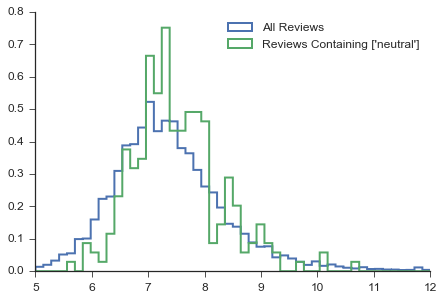

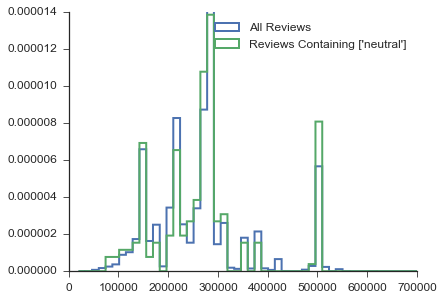

In [279]:
plt.figure()
plt.hist(rt['dale_chall'], range = [5,12], bins  = 50, histtype = 'step', lw = 2, normed = True, label = 'All Reviews')
plt.hist(fr['dale_chall'], range = [5,12], bins = 50, histtype = 'step', lw = 2, normed = True, label = 'Reviews Containing ' + str(keyword))
sns.despine()
plt.legend()
plt.xlim(5,12)

plt.figure()
plt.hist(rt['latest_zhvi'], range = [20000,700000], bins = 50, histtype = 'step', lw = 2, normed = True, label = 'All Reviews')
plt.hist(fr['latest_zhvi'], range = [20000,700000], bins = 50, histtype = 'step', lw = 2, normed = True, label = 'Reviews Containing ' + str(keyword))
sns.despine()
plt.legend()

In [281]:
#compute rolling gaussian means
rdf = RollingGaussianMean(rt, 'latest_zhvi', 'kw_freq', np.linspace(0,1000000,101), 20000.0)
tdf = RollingGaussianMean(rt, 'year', 'kw_freq', np.linspace(2006,2016,120), 0.5)
sdf = RollingGaussianMean(fr, 'latest_zhvi', 'stars', np.linspace(0,1000000,101), 20000.0)

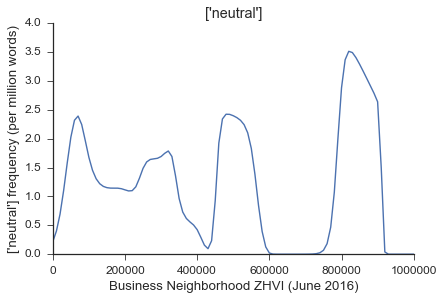

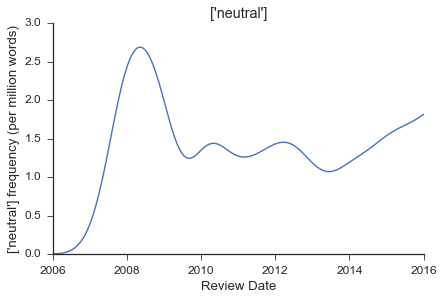

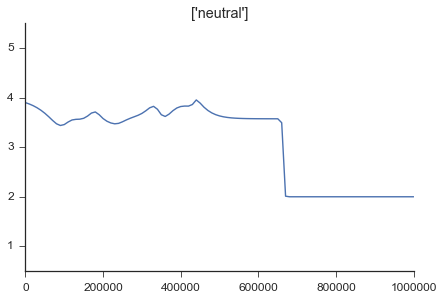

In [282]:
plt.figure()
plt.title(str(keyword))
plt.plot(rdf[0],rdf[1]*1000000)
plt.xlim(0,1000000)
plt.ylim(0,)
plt.ylabel(str(keyword) +' frequency (per million words)')
plt.xlabel('Business Neighborhood ZHVI (June 2016)')
sns.despine()

plt.figure()
plt.title(str(keyword))
plt.plot(tdf[0],tdf[1]*1000000)
plt.xlim(2006,2016)
plt.ylim(0,)
plt.ylabel(str(keyword) +' frequency (per million words)')
plt.xlabel('Review Date')
sns.despine()

plt.figure()
plt.title(str(keyword))
plt.plot(sdf[0],sdf[1])
#plt.scatter(fr['latest_zhvi'],fr['stars'])
plt.ylim(0.5,5.5)
sns.despine()

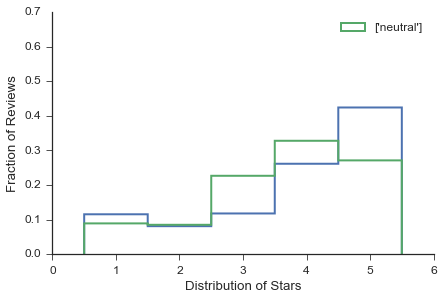

In [283]:
plt.hist(rt['stars'], range = [0.5,5.5], bins = 5, histtype = 'step', lw = 2, normed = True)
plt.hist(fr['stars'], range = [0.5,5.5], bins = 5, histtype = 'step', lw = 2, normed = True,\
        label = str(keyword))
plt.ylim(0,0.7)
plt.legend()
sns.despine()

plt.xlabel('Distribution of Stars')
plt.ylabel('Fraction of Reviews')

In [290]:
def CompareStars(dfA, dfB):
    
    if len(dfA) > len(dfB):
        samp = np.random.choice(dfA['stars'], size = len(dfB))
        exp = np.unique(samp, return_counts = True)[1]
        obs = np.unique(dfB['stars'], return_counts = True)[1]
        
    elif len(dfA) < len(dfB):
        samp = np.random.choice(dfB['stars'], size = len(dfA))
        exp = np.unique(dfA['stars'], return_counts = True)[1]
        obs = np.unique(samp, return_counts = True)[1]
        
    print(obs)
    print(exp)

    return(scipy.stats.chisquare(obs, exp).pvalue)

In [291]:
CompareStars(wi, wo)

[ 24  21  29  73 100]
[22 21 56 81 67]


4.366298922881476e-06

In [223]:
def BootstrapResample(X, n_iters, n = None):
    
    iters = []
    
    if isinstance(X, pd.Series):
        X = X.copy()
        X.index = range(len(X.index))
    if n == None:
        n = len(X)
    
    for i in range(n_iters):
        resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
        iters.append(np.array(X[resample_i]))
    
    hist_bag = []
    
    for sample in iters: #for every iteration
        hist_bag.append(np.unique(sample, return_counts = True)[1])
    
    hist_df = pd.DataFrame(hist_bag)
    hist_df = hist_df.apply(lambda x: x/len(X))
    
    star_means = np.array(hist_df.apply(np.mean))
    star_std = np.array(hist_df.apply(np.std))
    star = np.array([1,2,3,4,5])
    star_df = pd.DataFrame({'star': star, 'mean': star_means, 'std': star_std})
    
    return star_df, hist_df

In [273]:
wo_df, wo_hist = BootstrapResample(wo['stars'], 10)
wi_df, wi_hist = BootstrapResample(wi['stars'], 10)

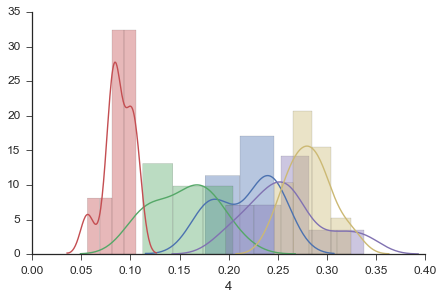

In [274]:
for col in fr_hist.columns:
    sns.distplot(fr_hist[col])
sns.despine()

In [268]:
scipy.stats.wilcoxon(fr_hist[3], rt_hist[3])

WilcoxonResult(statistic=22.0, pvalue=0.57506213017394969)

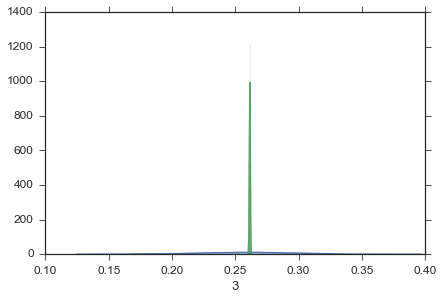

In [233]:
sns.distplot(fr_hist[3])
sns.distplot(rt_hist[3])

(0.5, 5.5)

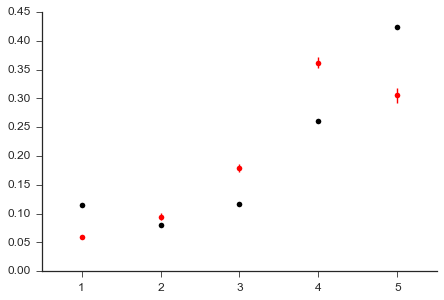

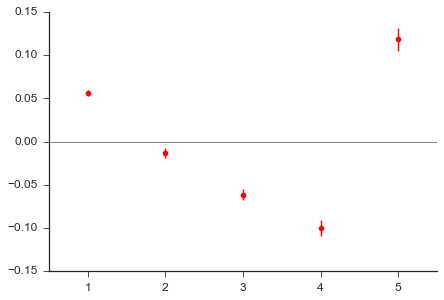

In [317]:
plt.figure()
plt.errorbar(wo_df['star'], wo_df['mean'], wo_df['std'], fmt = 'ko')
plt.errorbar(wi_df['star'], wi_df['mean'], wi_df['std'], fmt = 'ro')
sns.despine()
plt.xlim(0.5,5.5)
plt.ylim(0,)

plt.figure()
plt.errorbar(wo_df['star'], wo_df['mean'] - wi_df['mean'], np.sqrt(wo_df['std']**2.0 + wi_df['std']**2.0), fmt = 'ro')
plt.axhline(0, lw = 1, c = 'grey')
sns.despine()
plt.xlim(0.5,5.5)

In [128]:
#fr[['text']].to_csv('review_racism.csv')
bfr = pd.merge(b, fr, on = 'business_id')
brt = pd.merge(b, rt, on = 'business_id')

In [132]:
def CompareCounts(colA, colB):
    A = pd.DataFrame({'name': np.unique(colA, return_counts = True)[0],\
            'a_counts': np.unique(colA, return_counts = True)[1]})

    B = pd.DataFrame({'name': np.unique(colB, return_counts = True)[0],\
            'b_counts': np.unique(colB, return_counts = True)[1]})

    C = pd.merge(A,B, on = 'name')
    
    rel_size = sum(C['a_counts']/sum(C['b_counts']))
    
    C['ratio'] = (C['a_counts']/C['b_counts'])/rel_size

    return(C)

In [133]:
CompareCounts(bfr['state'],brt['state'])

,a_counts,name,b_counts,ratio
0,577,AZ,564382,0.990399
1,58,NC,114077,0.492535
2,449,NV,287983,1.510383
3,30,PA,78611,0.369697
4,4,WI,37999,0.101975
